In [43]:
import io
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import files

In [44]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['letters.data']), header=None)

Saving letters.data to letters (1).data


In [78]:
all_pixels = df.iloc[:, :35].values
all_outputs = df.iloc[:, 35:].values
my_pixels = np.array([])
my_outputs = np.array([])
example_set = [0, 6, 7, 11, 17, 18, 20, 23, 24, 25]
for id in example_set:
    my_pixels = np.append(my_pixels, all_pixels[id])
    outputs = np.array([])
    for id2 in example_set:
      outputs = np.append(outputs, all_outputs[id][id2])
    my_outputs = np.append(my_outputs, outputs)

my_pixels = my_pixels.reshape((-1, 35))
my_outputs = my_outputs.reshape((-1, 10))

In [93]:
class Genetics:
    def __init__(self):
        self.elite_percent = 0.1  # Procent najlepszych osobników przechodzących do nowego pokolenia
        self.parent_percent = 0.5  # Procent losowo wybranych par rodziców

    def fit(self, tests, answers, population_size=2000, iterations=1000):
        self.tests = tests
        self.answers = answers
        self.population_size = population_size
        # Obliczanie rozmiaru chromosomu na podstawie danych wejściowych i wyjściowych
        self.gen_size = len(answers[0]) * len(tests[0]) + len(answers[0])
        self.iterations = iterations
        # Geny dla mutacji w zakresie od -1 do 1 z krokiem 0.02
        # Wybrałem taką dokładność, która jest wystarczająca do poprawnego aktywowania, a jednocześnie niezbyt duża, aby mutacja była skuteczna
        self.possible_genes = np.linspace(-1, 1, num=101)
        # Tworzenie populacji losowo za pomocą losowych genów
        self.population = np.random.choice(self.possible_genes, size=(self.population_size, self.gen_size))

        # Dla wykresu
        best = []
        avg = []

        for iteration in range(self.iterations):
            results = self.selection()
            best.append(np.max(results))
            avg.append(np.mean(results))
            if self.evaluation(self.population[0]) == 1.0:
                break  # Jeżeli najlepszy osobnik osiągnął maksymalny wynik

        plt.plot(best, label='Najlepsze')
        plt.plot(avg, label='Średnie')
        plt.xlabel('Generacja')
        plt.ylabel('Dopasowanie')
        plt.title('Wydajność algorytmu genetycznego')
        plt.legend()
        plt.show()

    def evaluation(self, chromosome):
        # Przekształcanie jednowymiarowej tablicy chromosomu w macierze
        weights = chromosome[:self.gen_size - len(self.answers[0])].reshape(len(self.answers[0]), len(self.tests[0]))
        biases = chromosome[self.gen_size - len(self.answers[0]):].reshape(len(self.answers[0]))
        accuracy = 0
        for i in range(len(self.tests)):
            # Obliczanie wartości neuronów
            activations = np.dot(weights, self.tests[i].reshape(len(self.tests[0]))) + biases
            predictions = np.where(activations >= 0.0, 1, -1)
            # Porównywanie z oczekiwanymi wynikami
            for item, expected in zip(predictions, self.answers[i]):
                if item == expected:
                    accuracy += 1
        # Zwracanie dokładności osobnika
        # Dzielę wszystkie poprawne odpowiedzi przez iloczyn liczby pytań i liczby odpowiedzi w teście,
        # aby uzyskać dokładność w zakresie od 0 do 1 (łatwiej analizować na wykresie)
        return accuracy / (len(self.tests) * len(predictions))

    def selection(self):
        # Pobieranie numerów najlepszych osobników
        evaluations = [self.evaluation(chromosome) for chromosome in self.population]
        sorted_population = np.argsort(evaluations)[::-1]  # Odwracanie tablicy
        self.population = self.population[sorted_population]  # Sortowanie głównej tablicy
        elite_population = self.population[:int(self.population_size * self.elite_percent)]  # Wybieranie najlepszych 10% całej populacji
        new_population = []
        for _ in range(int(self.population_size - len(elite_population))):  # Pozostałe osobniki uzyskiwane przez krzyżowanie
            # Wybieranie rodziców
            parents_id = np.random.choice(int(self.population_size * self.parent_percent), 2, replace=False)
            parent1, parent2 = self.population[parents_id[0]], self.population[parents_id[1]]
            new_element = []
            # Losowe generowanie szansy na mutację i szansy na wybór genu od rodzica
            random_choices = np.random.choice([0, 1, 2], size=self.gen_size, p=[0.1, 0.45, 0.45])
            for i, choice in enumerate(random_choices):
                if choice == 0:
                    gene = np.random.choice(self.possible_genes)
                elif choice == 1:
                    gene = parent1[i]
                else:
                    gene = parent2[i]
                new_element.append(gene)
            new_population.append(new_element)
        self.population = np.concatenate((elite_population, new_population))  # Nowa populacja
        return evaluations

    def predict(self, X):
        # Funkcja działa prawie tak samo jak funkcja evaluation.
        # Zwraca wszystkie predykcje dla najlepszego osobnika
        weights = self.population[0][:self.gen_size - len(self.answers[0])].reshape(len(self.answers[0]), len(self.tests[0]))
        biases = self.population[0][self.gen_size - len(self.answers[0]):].reshape(len(self.answers[0]))
        all_predictions = []
        for i in range(len(X)):
            activations = np.dot(weights, X[i].reshape(len(X[0]))) + biases
            predictions = np.where(activations >= 0.0, 1, -1)
            all_predictions.append(predictions)
        return all_predictions

    def misclassified(self, X, y):
        # Funkcja wyświetla wyniki dla najlepszego osobnika
        weights = self.population[0][:self.gen_size - len(self.answers[0])].reshape(len(self.answers[0]), len(self.tests[0]))
        biases = self.population[0][self.gen_size - len(self.answers[0]):].reshape(len(self.answers[0]))
        global_accuracy = 0
        for i in range(len(X)):
            activations = np.dot(weights, X[i].reshape(len(X[0]))) + biases
            predictions = np.where(activations >= 0.0, 1, -1)
            accuracy = 0
            print(y[i], " -- ", predictions, end="")  # Wyświetlanie dla czytelności
            for item, expected in zip(predictions, y[i]):
                if item == expected:
                    accuracy += 1
            if accuracy != len(self.answers[0]):  # Pokazuje błąd, jeśli jest chociaż jedno niezgodne pytanie
                print(" : ", accuracy, " (BŁĄD) ")
            else:
                print(" : ", accuracy)
            global_accuracy += accuracy / len(predictions)
        # Wyświetlanie dokładności w zakresie od 0 do 1
        return global_accuracy / len(self.tests)


def show(X):
      fig, axes = plt.subplots(1, 10, figsize=(20,20))
      for i, ax in enumerate(axes.flatten()):
          image = X[i].reshape(7, 5)
          ax.imshow(image, cmap='gray_r')
          ax.axis('off')
      plt.show()


def damage(X,percent,seed = 1):
  rgen = np.random.RandomState(seed)
  result = np.array(X)
  count = int(X.shape[1]*percent/100)
  for index_example in range(len(X)):
    order = np.sort(rgen.choice(X.shape[1],count,replace = False))
    for index_pixel in order:
      result[index_example][index_pixel] *=-1
  return result

In [95]:
gen = Genetics()


In [62]:
damaged5 = damage(my_pixels ,5)
damaged15 = damage(my_pixels,15)
damaged40 = damage(my_pixels,40)


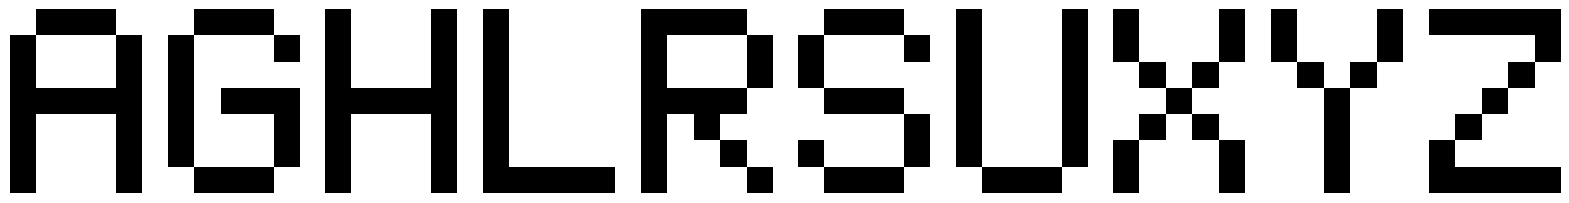

In [49]:
show(my_pixels)

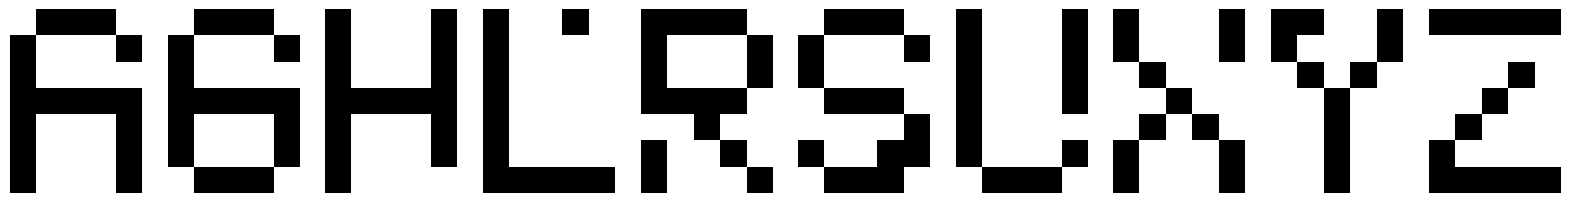

In [50]:
show(damaged5)

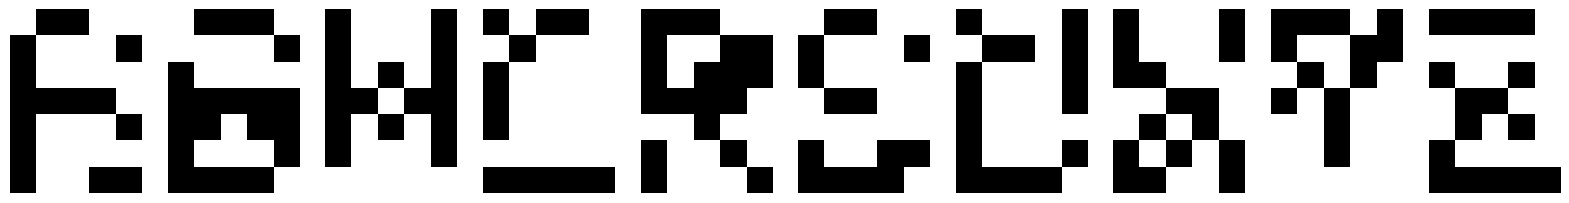

In [51]:
show(damaged15)

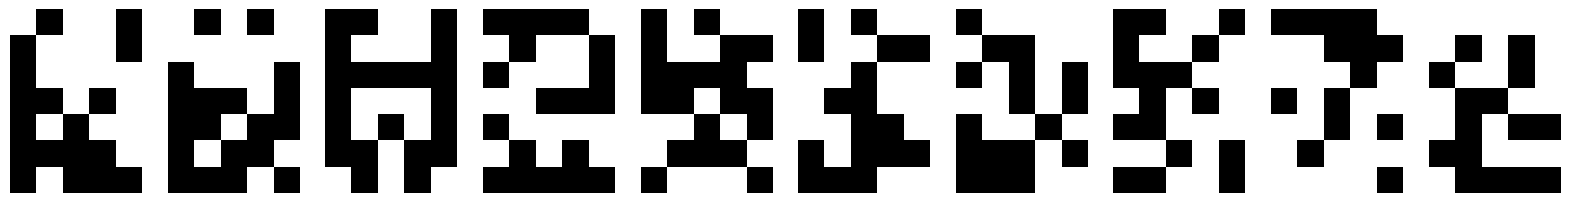

In [52]:
show(damaged40)

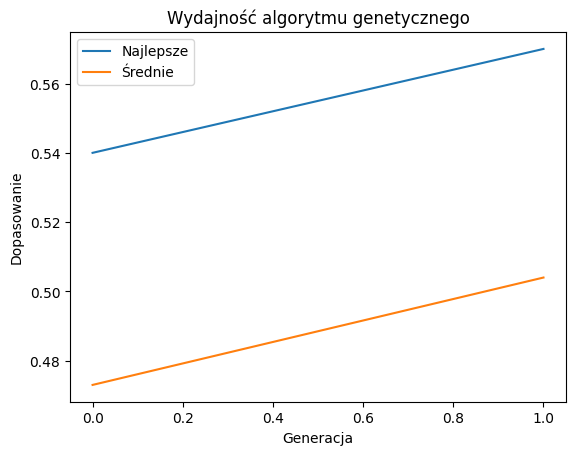

In [96]:
gen.fit(my_pixels,my_outputs)

In [75]:
gen.missclassified(my_pixels, my_outputs)

[-0.6   0.88 -0.58  0.   -0.78 -0.7   0.28  0.44 -0.18 -0.32 -0.12 -0.68
  0.64 -0.12  0.42  0.78  0.88 -0.86 -0.5   0.96 -0.66  0.52  0.34 -0.28
  0.44 -0.64 -0.82 -0.06  0.44  0.9   0.66 -0.48 -0.96 -0.66 -0.94 -1.
 -0.2   0.58  0.66 -0.86 -0.62  0.84  0.4   0.96 -0.46 -0.28  0.76 -0.04
 -0.4   0.52  0.48  0.54  0.88 -0.08 -0.22  0.96 -0.24  0.02  0.66 -0.94
  0.28  0.78  0.76 -0.4  -0.3  -0.42  0.64  0.02  0.88  0.12 -0.2   0.24
  0.78 -0.68 -0.02 -0.82  0.82  0.9  -0.16 -0.74  0.44 -0.36 -0.68  0.78
 -0.12  0.16  0.2  -0.54  0.18 -0.42 -0.86  0.16  0.48  0.34  0.54 -0.56
 -0.08 -0.52  0.16  0.5   0.26 -0.96  0.   -0.88 -0.5  -0.5   0.18 -0.38
 -0.28 -0.34 -0.44  0.88  0.74 -0.82 -0.92  0.32  0.58  0.78  0.4  -0.22
 -0.2   0.14 -0.48 -0.06  0.6   0.6   0.44  0.64  0.22 -0.94  0.74  0.42
  0.4  -0.9  -0.66  0.96  0.38  0.24  0.02 -0.28 -0.24  0.76  0.24 -0.1
  0.1  -0.08  0.8   0.96  0.74  0.1   0.16 -0.66  0.08 -0.42  1.   -0.72
  0.54 -0.92  0.24 -0.66  0.74 -0.24  0.74 -0.08 -0.04

0.99

In [68]:
gen.predict(my_pixels)

[array([ 1, -1, -1, -1, -1, -1, -1, -1, -1, -1]),
 array([-1,  1, -1, -1, -1, -1, -1, -1, -1, -1]),
 array([-1, -1,  1, -1, -1, -1, -1, -1, -1, -1]),
 array([-1, -1, -1,  1, -1, -1, -1, -1, -1, -1]),
 array([-1, -1, -1, -1,  1, -1, -1, -1, -1, -1]),
 array([-1, -1, -1, -1, -1,  1, -1, -1, -1, -1]),
 array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]),
 array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]),
 array([-1, -1, -1, -1, -1, -1, -1, -1,  1, -1]),
 array([-1, -1, -1, -1, -1, -1, -1, -1, -1,  1])]

In [76]:
gen.missclassified(damaged5, my_outputs)

[-0.6   0.88 -0.58  0.   -0.78 -0.7   0.28  0.44 -0.18 -0.32 -0.12 -0.68
  0.64 -0.12  0.42  0.78  0.88 -0.86 -0.5   0.96 -0.66  0.52  0.34 -0.28
  0.44 -0.64 -0.82 -0.06  0.44  0.9   0.66 -0.48 -0.96 -0.66 -0.94 -1.
 -0.2   0.58  0.66 -0.86 -0.62  0.84  0.4   0.96 -0.46 -0.28  0.76 -0.04
 -0.4   0.52  0.48  0.54  0.88 -0.08 -0.22  0.96 -0.24  0.02  0.66 -0.94
  0.28  0.78  0.76 -0.4  -0.3  -0.42  0.64  0.02  0.88  0.12 -0.2   0.24
  0.78 -0.68 -0.02 -0.82  0.82  0.9  -0.16 -0.74  0.44 -0.36 -0.68  0.78
 -0.12  0.16  0.2  -0.54  0.18 -0.42 -0.86  0.16  0.48  0.34  0.54 -0.56
 -0.08 -0.52  0.16  0.5   0.26 -0.96  0.   -0.88 -0.5  -0.5   0.18 -0.38
 -0.28 -0.34 -0.44  0.88  0.74 -0.82 -0.92  0.32  0.58  0.78  0.4  -0.22
 -0.2   0.14 -0.48 -0.06  0.6   0.6   0.44  0.64  0.22 -0.94  0.74  0.42
  0.4  -0.9  -0.66  0.96  0.38  0.24  0.02 -0.28 -0.24  0.76  0.24 -0.1
  0.1  -0.08  0.8   0.96  0.74  0.1   0.16 -0.66  0.08 -0.42  1.   -0.72
  0.54 -0.92  0.24 -0.66  0.74 -0.24  0.74 -0.08 -0.04

0.96

In [77]:
gen.missclassified(damaged15, my_outputs)

[-0.6   0.88 -0.58  0.   -0.78 -0.7   0.28  0.44 -0.18 -0.32 -0.12 -0.68
  0.64 -0.12  0.42  0.78  0.88 -0.86 -0.5   0.96 -0.66  0.52  0.34 -0.28
  0.44 -0.64 -0.82 -0.06  0.44  0.9   0.66 -0.48 -0.96 -0.66 -0.94 -1.
 -0.2   0.58  0.66 -0.86 -0.62  0.84  0.4   0.96 -0.46 -0.28  0.76 -0.04
 -0.4   0.52  0.48  0.54  0.88 -0.08 -0.22  0.96 -0.24  0.02  0.66 -0.94
  0.28  0.78  0.76 -0.4  -0.3  -0.42  0.64  0.02  0.88  0.12 -0.2   0.24
  0.78 -0.68 -0.02 -0.82  0.82  0.9  -0.16 -0.74  0.44 -0.36 -0.68  0.78
 -0.12  0.16  0.2  -0.54  0.18 -0.42 -0.86  0.16  0.48  0.34  0.54 -0.56
 -0.08 -0.52  0.16  0.5   0.26 -0.96  0.   -0.88 -0.5  -0.5   0.18 -0.38
 -0.28 -0.34 -0.44  0.88  0.74 -0.82 -0.92  0.32  0.58  0.78  0.4  -0.22
 -0.2   0.14 -0.48 -0.06  0.6   0.6   0.44  0.64  0.22 -0.94  0.74  0.42
  0.4  -0.9  -0.66  0.96  0.38  0.24  0.02 -0.28 -0.24  0.76  0.24 -0.1
  0.1  -0.08  0.8   0.96  0.74  0.1   0.16 -0.66  0.08 -0.42  1.   -0.72
  0.54 -0.92  0.24 -0.66  0.74 -0.24  0.74 -0.08 -0.04

0.8099999999999999

In [71]:
gen.missclassified(damaged40, my_outputs)

[-0.94  0.92  0.36  0.88 -0.18 -0.12  0.82  0.74 -0.86 -0.54 -0.46  0.98
  0.3  -0.44  0.56 -0.72 -0.64 -0.86  0.98  0.46  0.72 -0.18 -0.72  0.42
 -0.8  -0.8   0.12 -0.68  0.74  0.9   0.32 -0.46 -0.6   0.54  0.76 -0.36
  0.74  1.    0.62 -0.28 -0.94 -0.2   0.    0.64 -0.78 -0.22  0.76  0.74
  0.44  0.42 -0.7  -1.   -0.48 -0.04  0.68  0.2  -0.06 -0.82 -0.68 -0.08
 -0.08  0.88  0.16 -0.62 -0.5  -0.82 -0.06 -0.76  0.48 -0.86 -0.14 -0.34
 -0.66 -0.76  0.44 -0.4   0.1   0.76  0.88 -0.74 -0.72  0.82 -1.   -0.02
  0.9  -0.02  0.34 -0.3   0.42  0.64 -0.7   0.12  0.86 -0.34  0.7  -0.72
  0.34 -0.76  0.84  0.12 -0.4  -0.04 -0.9  -0.22  0.44  0.74 -0.5  -0.16
  0.68 -0.12 -0.7  -0.12  0.92  0.74 -0.88 -0.78  0.2  -0.58 -0.52 -0.88
 -0.08 -0.1  -0.92  0.32 -0.54 -0.6  -0.96 -0.54  0.94 -0.98 -0.66  0.78
 -0.84  0.46  0.06 -0.58  0.4  -0.26  0.   -0.28  0.7   0.16  0.54  0.78
 -0.7   0.24 -0.18  0.96  0.8  -0.66 -0.76  0.88  0.92 -0.4  -0.72 -0.2
  0.4  -0.74 -0.22  0.   -0.26 -0.56  0.28 -0.9  -0.

0.6